<a href="https://colab.research.google.com/github/CSID-DGU/2021-1-CECD3-SASO-2/blob/master/NLP/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NLP 분석

0. Colab에 라이브러리 설치

In [1]:
# !pip install pykospacing
!pip install konlpy



# #Google drive 
from google.colab import drive
drive.mount('/content/drive')

# #한글 폰트 
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




1. 라이브러리 로딩


In [2]:
import re
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import json

# from pykospacing import spacing
from konlpy.tag import Kkma
from konlpy.tag import Okt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# import soynlp
import nltk

kkma = Kkma()
okt = Okt()
plt.rc('font', family='NanumBarunGothic') 

Json 파싱작업


In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/nlp/txtTojson.txt'

#txt 파일 읽어서 ->  ,] 나오면 하나의 json 형식으로 만든다.

with open(path) as f:
    contents = f.read()

index = 0
count = 0
jsonList = []

print(len(contents))

while True:
  temp = contents[index:index+2]
  if temp == '],':
    jsonList.append(contents[count:index+1])
    count = index+2
  index +=1

  #break
  if len(contents) == index +1:
    break 

#jsonList 마다 json 형식으로 바꾸어서 저장 후 
jsonListSize = len(jsonList)
print(jsonListSize)

path = '/content/train_data/'

ReviewJson = []
for i in range(jsonListSize):
  ReviewJson.append(json.loads(jsonList[i]))

  #Train Data Json 형식으로 저장
  name = "t"+ str(i) + '.json'
  with open(path + name , 'w', encoding='utf-8') as make_file:

    json.dump(ReviewJson[i], make_file, indent="\t", ensure_ascii = False)

26723382
1163


2.전처리 과정

In [5]:
################# 테스트 #################


#tokenize 함수
def tokenize(doc):
  #형태소와 품사를 join
  return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]




# # 파일 위치
# reviewjson_path = '/content/drive/MyDrive/Colab Notebooks/nlp/test.json'
firstPath = '/content/train_data/t0.json'

df = pd.read_json(firstPath)


#dataFrame Concatnation
#jsonListSize
for i in tqdm(range(1,jsonListSize), desc="Json Data 합치기"):
  jsonPath = '/content/train_data/t' + str(i) + '.json'
   
  dfTemp = pd.read_json(jsonPath)
  df = pd.concat([df,dfTemp], ignore_index=True)




#review list 로 변환
newData = []
for i in tqdm(range(len(df)), desc="Tokenize 과정"):
  newData.append([df.text[i], df.avgStar[i]])

#tokenize 과정
new_docs = [(tokenize(row[0]), row[1]) for row in tqdm(newData)]


# print(new_docs)


################# 테스트 #################




In [11]:
#new_docs 저장

df = pd.DataFrame(new_docs) 
    
# saving the dataframe 
df.to_csv('new_docs_dataFrame.csv', encoding='utf-8-sig')  

토큰개수: 8984738
8984738
16091
[('하다/Verb', 370815), ('./Punctuation', 210562), ('이/Josa', 192197), ('\r\n/Foreign', 186523), ('상담/Noun', 156802), ('수술/Noun', 125101), ('은/Josa', 125099), ('도/Josa', 123157), ('에/Josa', 120969), ('님/Suffix', 112154), ('가/Josa', 98716), ('을/Josa', 91000), ('원장/Noun', 83175), ('해주다/Verb', 76455), ('받다/Verb', 74629), ('는/Josa', 72907), ('병원/Noun', 69055), ('같다/Adjective', 68508), ('있다/Adjective', 67602), ('가다/Verb', 54300)]


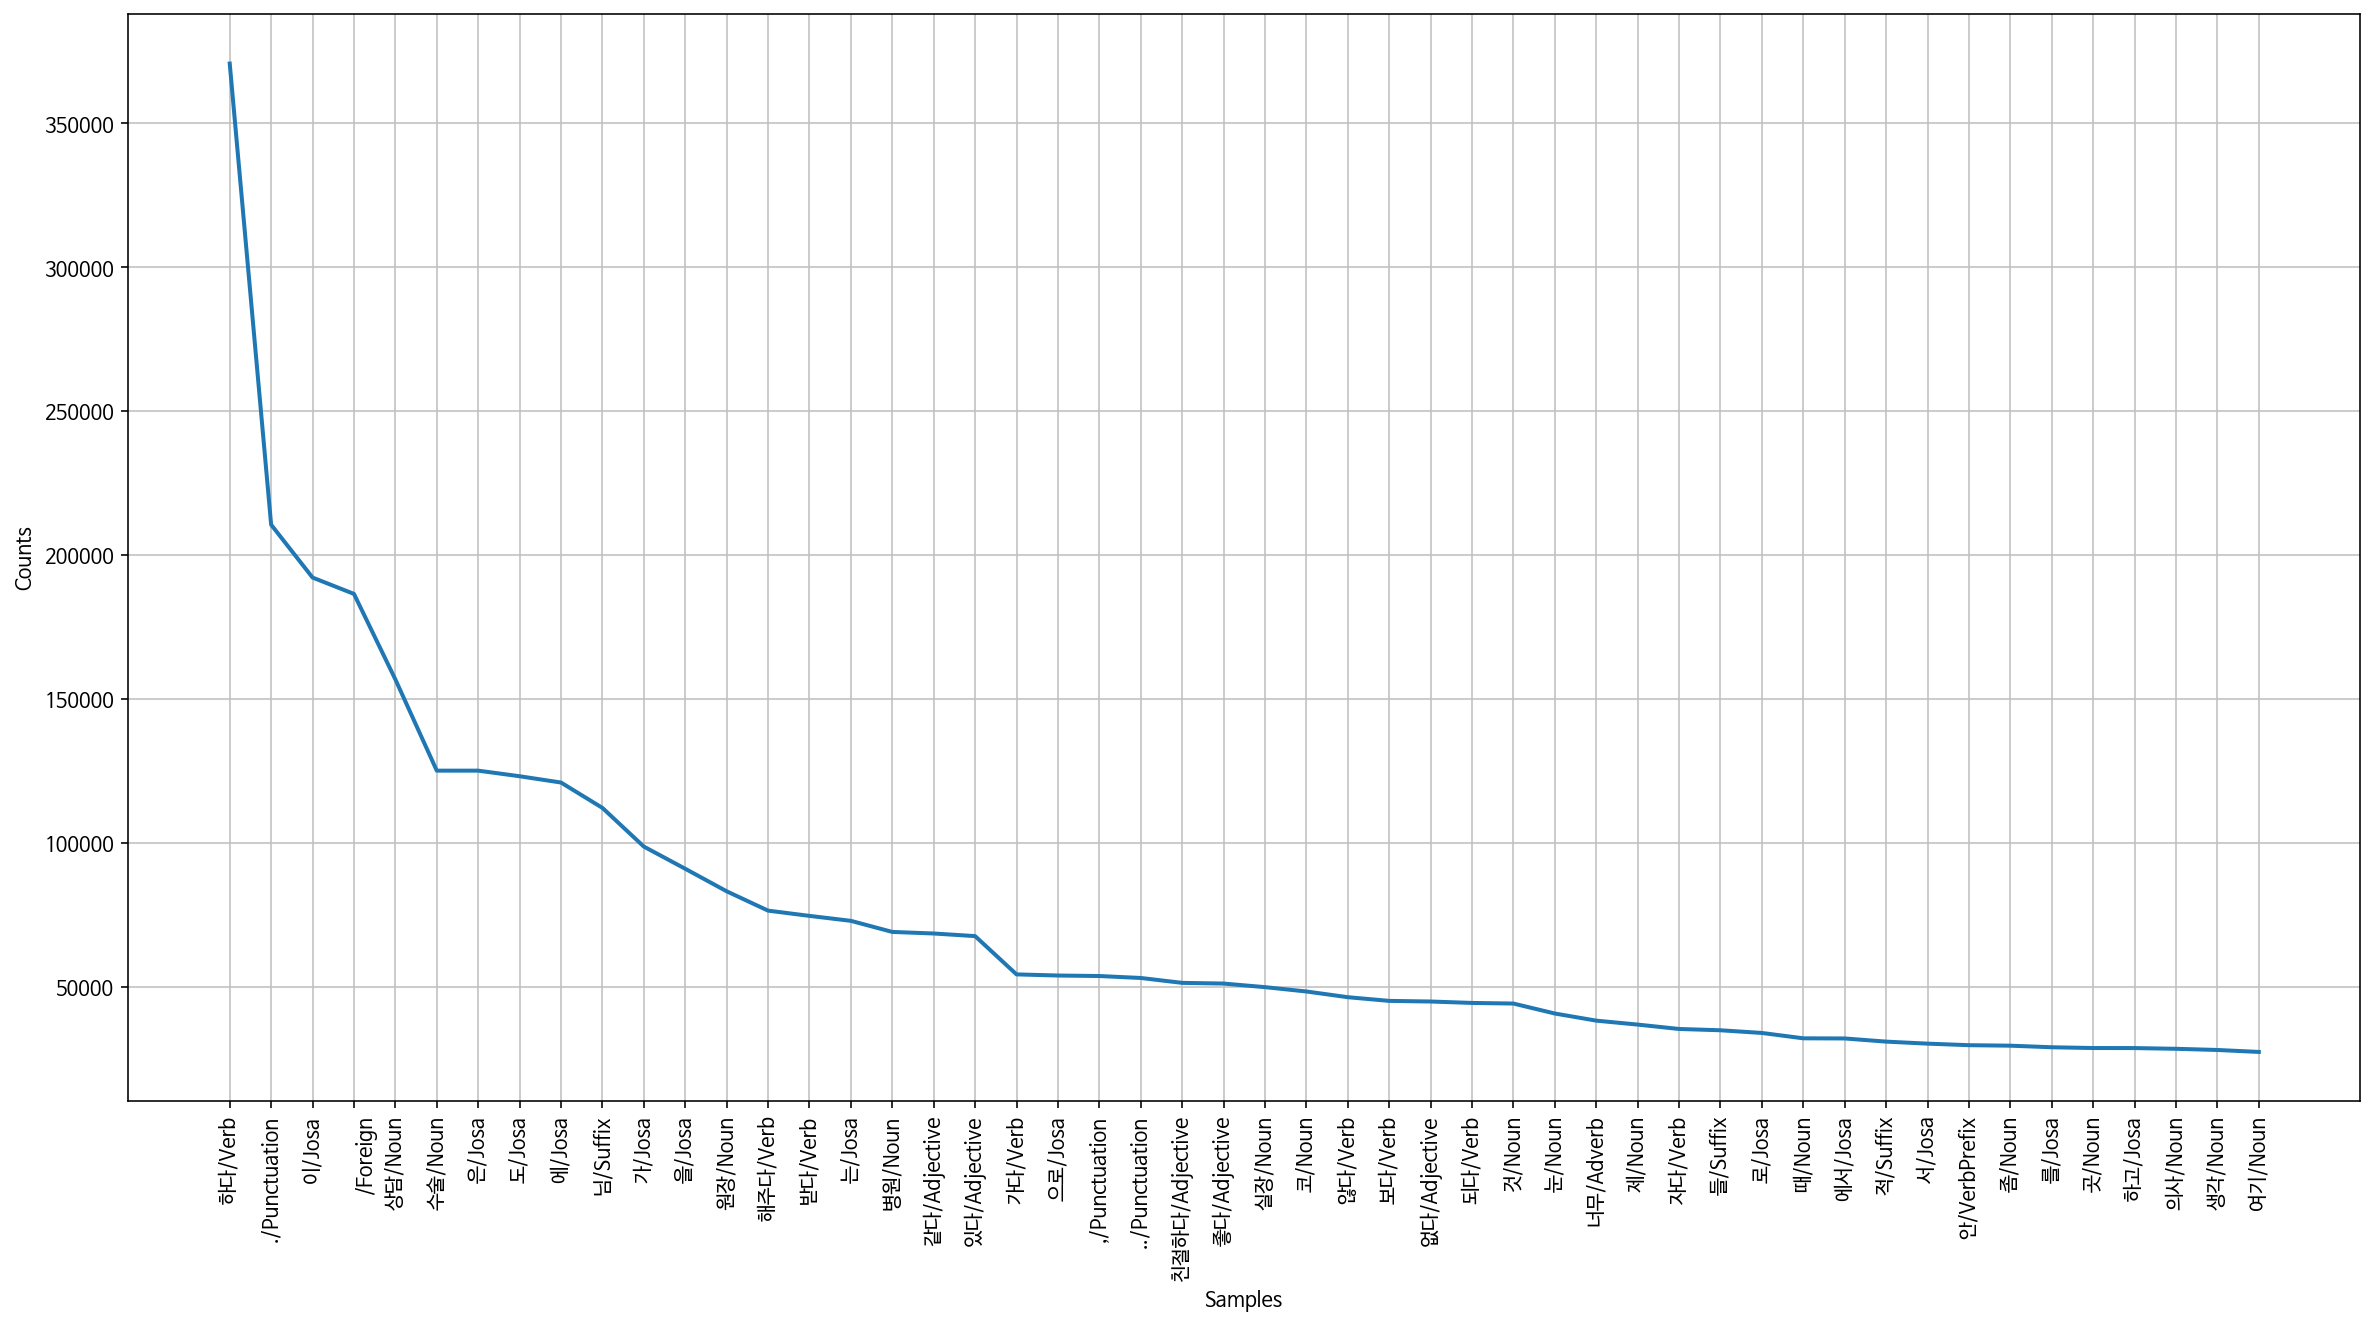

In [7]:
#토큰 구하기
tokens = [t for d in new_docs for t in d[0]]
print("토큰개수:", len(tokens))
# print(t okens)

#nltk 를 통한 전처리
text = nltk.Text(tokens, name='NMSC')

#토큰개수
print(len(text.tokens))

#중복을 제외한 토큰개수
print(len(set(text.tokens)))

#출력빈도가 높은 상위 토큰 10개
print(text.vocab().most_common(20))

#명사 출력
# noun = []
# noun = [t for d in new_docs for t in d[0] if 'Noun' in t]

# test = nltk.Text(noun, name='NMSC')
# print(len(set(test.tokens)))
# print(test.vocab().most_common(20))


# print(noun)




#상위 토큰 10개 matpolib 으로 출력
plt.figure(figsize=(20,10))
text.plot(50)


In [8]:
 
#모델을 만들기 위해 벡터화
#문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW(Bag of Words) 인코딩한 벡터를 만드는 역할
FREQUENCY_COUNT = 300;
selected_words = [f[0] for f in text.vocab().most_common(FREQUENCY_COUNT)]

#단어리스트 문서에서 상위 1000개들중 포함되는 단어들이 개수
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]


x_new = [term_frequency(d) for d,_ in new_docs]
#라벨(1 or 0)
y_new = [c/100 for _,c in new_docs]

#float 형으로 형변환
x_new = np.asarray(x_new).astype('float32')
y_new = np.asarray(y_new).astype('float32')

#레이어 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(FREQUENCY_COUNT,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#학습 프로세스 설정
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=[tf.keras.metrics.binary_accuracy]
    )

#학습 데이터로 학습
model.fit(x_new, y_new, epochs=10, batch_size=512)


results = model.evaluate(x_new, y_new)

results


#모델을 저장해둘수도 있다.
model.save('review_model.h5')




Epoch 1/10
221/221 [==============================] - 2s 4ms/step - loss: 0.6058 - binary_accuracy: 0.0385
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5618 - binary_accuracy: 0.0378
Epoch 3/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5514 - binary_accuracy: 0.0400
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5466 - binary_accuracy: 0.0399
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5429 - binary_accuracy: 0.0399
Epoch 6/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5408 - binary_accuracy: 0.0390
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5387 - binary_accuracy: 0.0404
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5375 - binary_accuracy: 0.0398
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5371 - binary_accuracy: 0.0389
Epoch 10/10
3524/3524 [==============

In [12]:

# 모델 불러오기
#from keras.models import load_model
#model = load_model('review_model.h5')



def predict_review(review):
    token = tokenize(review)
    tfq = term_frequency(token)
    data = np.expand_dims(np.asarray(tfq).astype('float32'), axis=0)
    score = float(model.predict(data))

    if score > 0.5:
        print(f"{review} ==> 긍정 ({round(score*100)}%)")
    else:
        print(f"{review} ==> 부정 ({round((1-score)*100)}%)")


predict_review("유튜브에서 보던 느낌 그대로 상담 하세요 김태규 원장님. 그러나 자신만의 확고한 철학이 잇으셔서 그런지 타 병원 상담때와 대치되는 말을 몇개 하심 제 피부탄력이나 턱모양등... 결정적으로 후기사진이 하나 같이 몽달귀신 st 턱이어서 별로엿음")
predict_review('안면윤곽 상담받았어요 생각보다 병원에 사람이 많아요 김태규 원장님과 상담받았고 수술비용은 다른 병원에 바해서 조금 싼거같습니다. 원장님은 전문성 있어보였고 사람이 많아서 대기시간이 갈고 오래 기다린거 외엔 괜찮았습니다.')
predict_review('잘모르겠음 여러곳상담다녀봤는데 특별히다른거없는 그냥 완전평범한 성형외과임 근데 상담을 짧게함 대체 몇백들여서 얼굴만드는수술하는데 30분도안되는 상담받고서 어떻게하겠다는거임? 상담만받고 거른거같음 . . .')
predict_review('이 병원 너무 별로네요 왜이리 수술이라던지 여드름 치료가 별로인지 모르겠어오 어떻게 하겠다는거에요')
predict_review('후기보니까 눈 쪽 괜찮게 하시는 것 같아서 찾아갔어요. 상담도 친절하시고 나쁘지 않았는데 지금 수술 후 4주 차인데 붓기 빠질 기미가 안보이네요.')
predict_review('후기보니까 눈 쪽은 괜찮게 하시는 것 같아서 찾아갔어요. 상담도 친절하시고나쁘지 않았는데 전후 피드백이나 디테일한 부분른 별로네요 지금 수술 후 4주 차인데 붓기 빠질 기미도 안보이네요.')

유튜브에서 보던 느낌 그대로 상담 하세요 김태규 원장님. 그러나 자신만의 확고한 철학이 잇으셔서 그런지 타 병원 상담때와 대치되는 말을 몇개 하심 제 피부탄력이나 턱모양등... 결정적으로 후기사진이 하나 같이 몽달귀신 st 턱이어서 별로엿음 ==> 긍정 (68%)
안면윤곽 상담받았어요 생각보다 병원에 사람이 많아요 김태규 원장님과 상담받았고 수술비용은 다른 병원에 바해서 조금 싼거같습니다. 원장님은 전문성 있어보였고 사람이 많아서 대기시간이 갈고 오래 기다린거 외엔 괜찮았습니다. ==> 긍정 (68%)
잘모르겠음 여러곳상담다녀봤는데 특별히다른거없는 그냥 완전평범한 성형외과임 근데 상담을 짧게함 대체 몇백들여서 얼굴만드는수술하는데 30분도안되는 상담받고서 어떻게하겠다는거임? 상담만받고 거른거같음 . . . ==> 부정 (50%)
이 병원 너무 별로네요 왜이리 수술이라던지 여드름 치료가 별로인지 모르겠어오 어떻게 하겠다는거에요 ==> 부정 (79%)
후기보니까 눈 쪽 괜찮게 하시는 것 같아서 찾아갔어요. 상담도 친절하시고 나쁘지 않았는데 지금 수술 후 4주 차인데 붓기 빠질 기미가 안보이네요. ==> 부정 (50%)
후기보니까 눈 쪽은 괜찮게 하시는 것 같아서 찾아갔어요. 상담도 친절하시고나쁘지 않았는데 전후 피드백이나 디테일한 부분른 별로네요 지금 수술 후 4주 차인데 붓기 빠질 기미도 안보이네요. ==> 부정 (53%)
